In [1]:
import re
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from graphviz import *
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


In [53]:
def load_dfs(word_list):
    df = pd.DataFrame()
    for word in word_list:
        dfaux = pd.read_csv('2019-10-15\/' + word + '.csv'     )
        dfaux['word'] = word
        df = df.append(dfaux)
    return df.reset_index(drop=True)


def get_hashtag(string):
    return re.findall(r'\#\w+', string)


def get_intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))


def build_graph(word_list,edges,filename):
#    g = Digraph('G', filename=filename + '.gv', engine='sfdp', format='png')
    g = Graph(  'G', filename=filename + '.gv', engine='sfdp', format='png')

    for node in word_list:
        g.node(node)
    for edge in edges:
        g.edge(edge[0],edge[1], len='2.00')
    return g


def get_directional_edges(df, combos):
    edges     = []
    for pair in combos:
        len1 = len(df[(df['word'] == pair[0]) & df['tweet.text'].str.contains('#' + pair[1])])
        len2 = len(df[(df['word'] == pair[1]) & df['tweet.text'].str.contains('#' + pair[0])])
        if len1 > len2:
            edges.append((pair[0],pair[1]))
        else:
            edges.append((pair[1],pair[0]))        
    return edges


def get_nodes_edges_treshold(df, nnodes, threshold):
    # gets the list of the nnodes most used hashtags in the df
    # this is the list of nodes one wants in the graph
    dfaux      = df.copy()
    dfaux['#'] = dfaux.apply(lambda x: get_hashtag(x['tweet.text']), 1)
    merged     = pd.Series(list(itertools.chain(*dfaux['#'].tolist()))).value_counts()[0:nnodes]

    # for each of these hashtags (nodes) filters the df rows containing that hashtag
    # and check which other hashtags are presente in the filtered df
    # finally it counts the number of tweets with the second hashtag and check
    # if a threshold is passed (this identify the edges).
    edges = []
    for node in merged.keys():
        aux   = list(itertools.chain(*(dfaux[dfaux['tweet.text'].str.contains(node)]['#'].tolist())))
        aux   = get_intersection(merged.keys(),aux)
        aux.remove(node)
        for a in aux:
            if ((node[1:],a[1:]) not in edges) and ((a[1:],node[1:]) not in edges):
                if len(dfaux[dfaux['tweet.text'].str.contains(a)]) > threshold:
                    edges.append((node[1:],a[1:]))
    nodes = [x[1:] for x in merged.keys()]
    return nodes, edges



In [54]:
word_list = ['furniture', 'homedecor', 'interiordesign']
combos    = list(itertools.combinations(word_list,2))


df_tweets = load_dfs(word_list)
edges     = get_directional_edges(df_tweets, combos)
g         = build_graph(word_list,edges,'test_0.1')

g
#g.view()

'test_0.1.gv.png'

In [55]:
print(len(df_tweets))
dftest = df_tweets.copy()
dftest.drop_duplicates(subset=['tweet.id'],keep=False, inplace=True)
print(len(dftest))

3863
2966


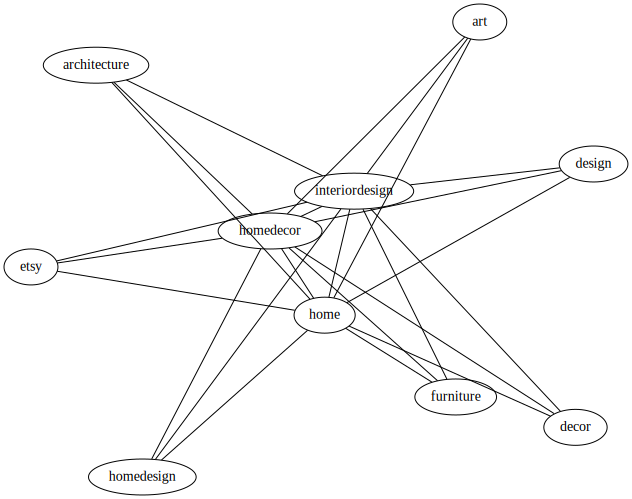

In [58]:
nnodes       = 10
threshold    = 1000
nodes, edges = get_nodes_edges_treshold(dftest, nnodes, threshold)
g            = build_graph(nodes,edges,'test_0.2')


g
#g.view()